In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')

from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
from pyspark.ml.feature import VectorAssembler
import pandas as pd

In [2]:


def mean(a_list):
    return sum(a_list)/len(a_list)

spark = SparkSession.builder.appName("algoSelection").getOrCreate()
heart = spark.read.csv("prepared_heart_data.csv", header=True, inferSchema=True)

23/10/11 22:24:53 WARN Utils: Your hostname, Stephens-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.8 instead (on interface en0)
23/10/11 22:24:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/11 22:24:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/11 22:24:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/10/11 22:24:55 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/10/11 22:24:55 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [3]:
train = heart.filter(heart.partition == "train").drop("partition")

feature_columns = [col_name for col_name in train.columns if col_name != "target"]
target_column = "target"
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
transformed_train = assembler.transform(train)

print((heart.count(), len(heart.columns)))

(447, 15)


23/10/11 22:26:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


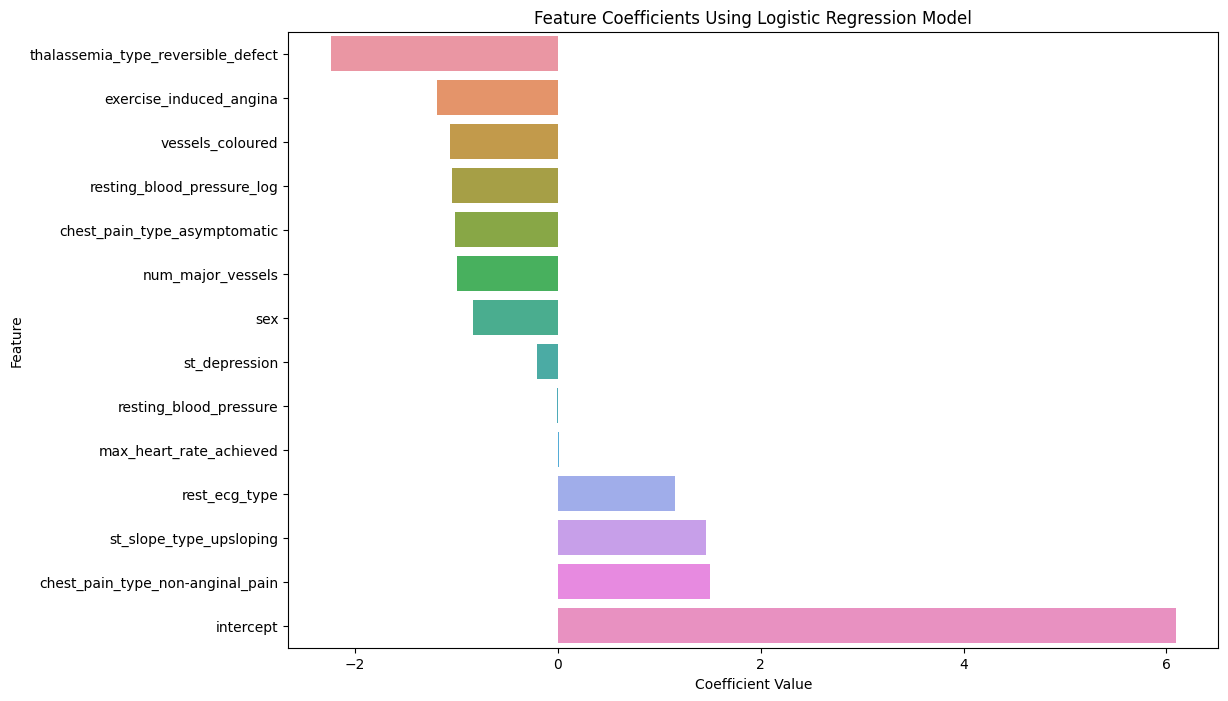

In [4]:
from pyspark.ml.classification import LogisticRegression
logistic = LogisticRegression(featuresCol="features", labelCol=target_column)
logistic = logistic.fit(transformed_train)

coefficients = logistic.coefficients.toArray()

coef_scores = sorted(list(zip(feature_columns, coefficients)) + [("intercept", logistic.intercept)], key=lambda x: x[1])

feature_importance = pd.DataFrame.from_records(coef_scores, columns = ["Coefficient", "Importance"])

# Create a barplot to visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(y="Coefficient", x="Importance", data=feature_importance)
plt.title("Feature Coefficients Using Logistic Regression Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

In [5]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="target", seed=722)
dt_model = dt.fit(transformed_train)

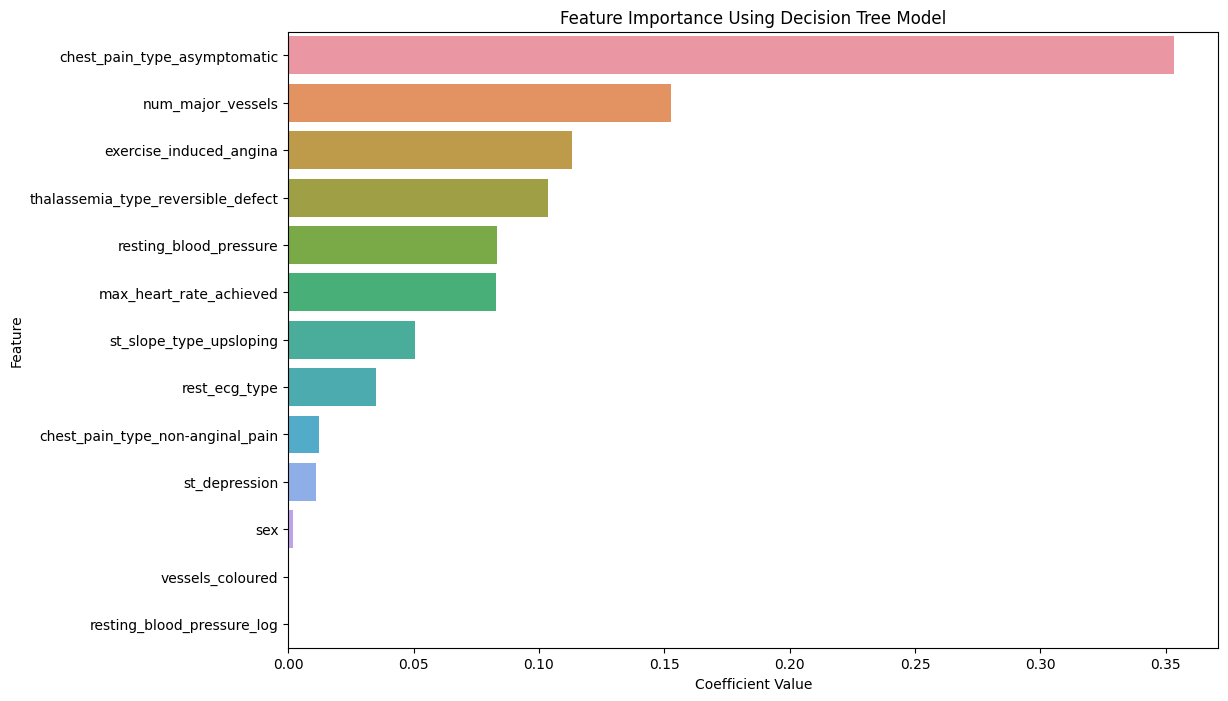

In [6]:
coefficients = dt_model.featureImportances.toArray()
coef_scores = sorted(list(zip(feature_columns, coefficients)), key=lambda x: x[1], reverse=True)

feature_importance = pd.DataFrame.from_records(coef_scores, columns = ["Coefficient", "Importance"])

# Create a barplot to visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(y="Coefficient", x="Importance", data=feature_importance)
plt.title("Feature Importance Using Decision Tree Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

In [7]:
def print_tree(tree):
    print("Decision Tree Structure (Text Representation):")
    string_tree = str(tree.toDebugString)
    string_tree = string_tree[string_tree.find(", depth")+2:]
    for i in range(len(feature_columns)-1,-1,-1):
        string_tree = string_tree.replace(f"feature {i}", feature_columns[i])
    print(string_tree)


print_tree(dt_model)


Decision Tree Structure (Text Representation):
depth=5, numNodes=43, numClasses=2, numFeatures=13
  If (chest_pain_type_asymptomatic <= 0.5)
   If (thalassemia_type_reversible_defect <= 0.5)
    If (num_major_vessels <= 1.5)
     If (resting_blood_pressure <= 150.5)
      Predict: 1.0
     Else (resting_blood_pressure > 150.5)
      If (chest_pain_type_non-anginal_pain <= 0.5)
       Predict: 0.0
      Else (chest_pain_type_non-anginal_pain > 0.5)
       Predict: 1.0
    Else (num_major_vessels > 1.5)
     If (max_heart_rate_achieved <= 152.5)
      Predict: 0.0
     Else (max_heart_rate_achieved > 152.5)
      Predict: 1.0
   Else (thalassemia_type_reversible_defect > 0.5)
    If (st_slope_type_upsloping <= 0.5)
     If (max_heart_rate_achieved <= 176.5)
      Predict: 0.0
     Else (max_heart_rate_achieved > 176.5)
      If (exercise_induced_angina <= 0.5)
       Predict: 1.0
      Else (exercise_induced_angina > 0.5)
       Predict: 0.0
    Else (st_slope_type_upsloping > 0.5)
     

# Objective 2

In [8]:
from pyspark.ml.classification import (
    LogisticRegression,
    RandomForestClassifier,
    DecisionTreeClassifier,
    GBTClassifier,
    NaiveBayes,
)
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


classifiers = [
    LogisticRegression(featuresCol="features", labelCol="target", maxIter=10000),
    RandomForestClassifier(featuresCol="features", labelCol="target", seed=722),
    DecisionTreeClassifier(featuresCol="features", labelCol="target", seed=722),
    GBTClassifier(featuresCol="features", labelCol="target", seed=722),
    NaiveBayes(featuresCol="features", labelCol="target"),
]

eval_metrics = ["AUC", "accuracy", "weightedRecall", "weightedPrecision", "f1"]
eval_results = {metric:[] for metric in eval_metrics}


for metric in eval_metrics:
    if metric == "AUC":
        evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction", metricName="areaUnderROC")
    else:
        evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName=metric)
    for classifier in classifiers:
        
        paramGrid = ParamGridBuilder().build()

        cv = CrossValidator(
            estimator=classifier,
            estimatorParamMaps=paramGrid,
            evaluator=evaluator,
            numFolds=10,
            seed=722
        )

        cvModel = cv.fit(transformed_train)
        eval_results[metric] += [round(cvModel.avgMetrics[0],4)]

23/10/11 22:30:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [9]:
classifier_names = ["Logistic Regression",
                    "Random Forest",
                    "Decision Tree",
                    "Gradient Boosted Trees",
                    "Naive bayes"]


print(f"{'':^22}", end=" | ")
for metric in eval_metrics+["average"]:
    print(f"{metric:^17}", end=" | ")
print()
for i in range(len(classifier_names)):
    print("-"*23+"+"+("-"*19+"+")*6)
    print(f"{classifier_names[i]:<22}", end=" | ")
    for metric in eval_results:
        print(f"{eval_results[metric][i]:^17}", end=" | ")
    print(f"{round(sum([eval_results[metric][i] for metric in eval_results])/len(eval_results), 4):^17}", end=" |\n")
print("-"*23+"+"+("-"*19+"+")*6)

                       |        AUC        |     accuracy      |  weightedRecall   | weightedPrecision |        f1         |      average      | 
-----------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
Logistic Regression    |      0.8721       |      0.8718       |      0.8718       |      0.8761       |      0.8718       |      0.8727       |
-----------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
Random Forest          |      0.8697       |      0.8707       |      0.8707       |      0.8768       |      0.8703       |      0.8716       |
-----------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
Decision Tree          |      0.8921       |      0.8896       |      0.8896       |      0.8955       |      0.8898       |     